In [4]:
import arviz as az
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import pymc as pm
from sklearn.preprocessing import scale
import seaborn as sns

%matplotlib inline

In [25]:


class CRM:
    def __init__(self, num_patients, num_doses):
        self.num_patients = num_patients
        self.num_doses = num_doses
        self.allocated_doses = np.ones(self.num_patients, dtype=int) * -1

    def tangent_model(dose_label, alpha):
        return ((np.tanh(dose_label) + 1.) / 2.) ** alpha
    
    def logistic_model(dose_label, alpha, beta):
        '''
        alpha: intercept
        beta: 
        '''
        return (np.exp(alpha + dose_label * np.exp(beta)))\
                / (1. + np.exp(alpha + dose_label * np.exp(beta)))
    
    def init_tangent_labels(p_true_val, a0):
        x = (p_true_val ** (1. / a0) * 2. - 1.)
        return 1./2. * np.log((1. + x)/(1. - x))
    
    def init_logistic_labels(p_true_val, a0, b0):
        return (np.log(p_true_val / (1. - p_true_val)) - a0) / np.exp(b0)

    def gen_patients(self, arr_rate):
        '''
        Generates all patients for an experiment of length T
        '''
        # Arrival proportion of each subgroup. If arrive_rate = [5, 4, 3],
        # arrive_dist = [5/12, 4/12, 3/12]
        arrive_sum = sum(arr_rate)
        arrive_dist = [rate/arrive_sum for rate in arr_rate]
        arrive_dist.insert(0, 0)

        # [0, 5/12, 9/12, 12/12]
        arrive_dist_bins = np.cumsum(arrive_dist)

        # Random numbers between 0 and 1 in an array of shape (1, T)
        patients_gen = np.random.rand(self.num_patients)
        patients = np.digitize(patients_gen, arrive_dist_bins) - 1
        return patients

    def from_posterior(param, samples):
        smin, smax = np.min(samples), np.max(samples)
        width = smax - smin
        x = np.linspace(smin, smax, 100)
        samples = samples[0]
        y = stats.gaussian_kde(samples)(x)

        # what was never sampled should have a small probability but not 0,
        # so we'll extend the domain and use linear approximation of density on it
        x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
        y = np.concatenate([[0], y, [0]])
        return pm.Interpolated(param, x, y)
    
    def plot_dose_toxicity_curve(dose_labels, p_true, alpha):
        sns.set_theme()
        model_toxicities = CRM.tangent_model(dose_labels, alpha)
        frame = pd.DataFrame({'dose_labels': dose_labels,
                              'model': model_toxicities,
                              'true': p_true.mean(axis=0)})
        frame = pd.melt(frame, id_vars=['dose_labels'], var_name='toxicity', value_name='toxicity_value')
        sns.lineplot(data=frame, x='dose_labels', y='toxicity_value', hue='toxicity', markers=True)

    def run_trial(self, dose_labels, patients, p_true, tox_thre):
        cohort_size = 3
        max_dose = 0
        timestep = 0
        curr_s = patients[:cohort_size]

        # Assign first patient to lowest dose level
        self.allocated_doses[:cohort_size] = 0
        X = np.array([dose_labels[0] for patient_idx in range(cohort_size)])

        # Sample toxicity
        Y = np.array([int(np.random.rand() <= p_true[subgroup_idx, self.allocated_doses[timestep]]) for subgroup_idx in curr_s])

        model = pm.Model()
        with model:
            # Prior of parameters
            alpha = pm.Gamma("alpha", 1, 1)

            # Expected value of outcome: dose-toxicity model
            toxicity_prob = CRM.tangent_model(X, alpha)

            # Likelihood (sampling dist) of observations
            Y_obs = pm.Bernoulli("Y_obs", toxicity_prob, observed=Y)

            # Draw 1000 posterior samples
            trace = pm.sample(25000, cores=1, target_accept=0.95)
            print(az.summary(trace, round_to=2))

            current_alpha_dist = trace.posterior['alpha']
            expected_toxicities = CRM.tangent_model(dose_labels, 1. / np.e)
            print(expected_toxicities)
            CRM.plot_dose_toxicity_curve(dose_labels, p_true, current_alpha_dist.values.mean())
            plt.show()

        timestep += cohort_size

        while timestep < self.num_patients:
            # Sample more data
            curr_s = patients[timestep - cohort_size:timestep]
            print(f"curr_s: {curr_s}")

            # If skipping doses is allowed, assign to the dose whose expected toxicity
            # under the posterior dist is closest to the threshold.
            expected_toxicities = CRM.tangent_model(dose_labels, current_alpha_dist.values.mean())
            selected_dose = np.abs(np.array(expected_toxicities) - tox_thre).argmin()
            if selected_dose > max_dose + 1:
                selected_dose = max_dose + 1
                max_dose = selected_dose
            print(expected_toxicities)
            print(f"Selected dose: {selected_dose}")
            self.allocated_doses[:cohort_size] = selected_dose
            X = np.array([dose_labels[selected_dose] for patient_idx in range(cohort_size)])
            # Sample toxicity
            Y = np.array([int(np.random.rand() <= p_true[subgroup_idx, self.allocated_doses[timestep]]) for subgroup_idx in curr_s])
            print(X, Y)
            model = pm.Model()
            with model:
                # Priors are posteriors from previous iteration
                alpha = CRM.from_posterior("alpha", trace.posterior["alpha"])

                # Expected value of outcome: dose-toxicity model
                toxicity_prob = CRM.tangent_model(X, alpha)

                # Likelihood (sampling dist) of observations
                Y_obs = pm.Bernoulli("Y_obs", toxicity_prob, observed=Y)

                # draw 10000 posterior samples
                trace = pm.sample(25000, cores=1, target_accept=0.95)
                    
                print(az.summary(trace, round_to=2))
                current_alpha_dist = trace.posterior['alpha']
                print(current_alpha_dist.values.mean())
                CRM.plot_dose_toxicity_curve(dose_labels, p_true, current_alpha_dist.values.mean())
                plt.show()

            timestep += cohort_size

                
def main():
    tox_thre = 0.35
    # toxicity
    p_true = np.array([[0.01, 0.01, 0.05, 0.15, 0.20, 0.45],
                    [0.01, 0.05, 0.15, 0.20, 0.45, 0.60],
                    [0.01, 0.05, 0.15, 0.20, 0.45, 0.60]])
    arr_rate = [5, 4, 3]
    crm = CRM(30, 5)
    dose_skeleton = np.mean(p_true, axis=0)
    dose_labels = CRM.init_tangent_labels(dose_skeleton, 1. / np.e)
    patients = crm.gen_patients(arr_rate)
    crm.run_trial(dose_labels, patients, p_true, tox_thre)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 29 seconds.


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  1.14  1.01    0.04     2.99       0.01     0.01  14164.26  16817.03   

       r_hat  
alpha    1.0  
[0.01       0.03666667 0.11666667 0.18333333 0.36666667 0.55      ]


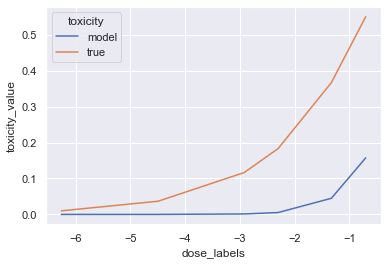

curr_s: [1 1 2]
[6.50221803e-07 3.61924380e-05 1.29905817e-03 5.25847779e-03
 4.48835371e-02 1.57333052e-01]
Selected dose: 1
[-4.493104 -4.493104 -4.493104] [1 1 1]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 176 seconds.
There were 12477 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.871, but should be close to 0.95. Try to increase the number of tuning steps.
There were 24987 divergences after tuning. Increase `target_accept` or reparameterize.


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.05  0.05     0.0     0.13        0.0      0.0   3055.96   4109.78   

       r_hat  
alpha    1.0  
0.048002433232778176


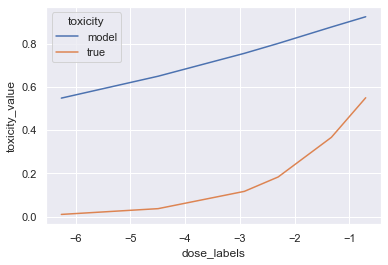

curr_s: [0 0 0]
[0.54831701 0.6496212  0.75552937 0.80142833 0.87729233 0.9249568 ]
Selected dose: 0
[-6.25907339 -6.25907339 -6.25907339] [1 0 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 50 seconds.
There were 999 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1323 divergences after tuning. Increase `target_accept` or reparameterize.


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.07  0.04    0.01     0.15        0.0      0.0   7772.19    7154.1   

       r_hat  
alpha    1.0  
0.06975779175307288


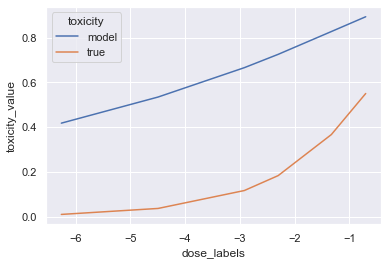

curr_s: [0 2 2]
[0.41759696 0.53426316 0.6653853  0.72492797 0.8267545  0.89282682]
Selected dose: 0
[-6.25907339 -6.25907339 -6.25907339] [0 0 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 48 seconds.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
There were 270 divergences after tuning. Increase `target_accept` or reparameterize.


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.11  0.08    0.03      0.2        0.0      0.0   4763.71   2178.37   

       r_hat  
alpha    1.0  
0.11453279313499788


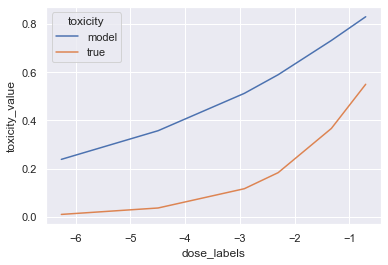

curr_s: [0 0 0]
[0.23841588 0.35728202 0.51228341 0.58968921 0.73171772 0.83016896]
Selected dose: 1
[-4.493104 -4.493104 -4.493104] [0 0 1]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 38 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.11  0.04    0.04     0.19        0.0      0.0  11522.66  11409.68   

       r_hat  
alpha    1.0  
0.11150483363549187


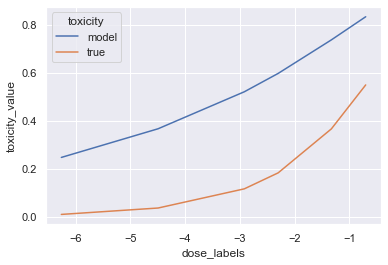

curr_s: [0 0 2]
[0.24762636 0.36713723 0.52142292 0.59798092 0.73778529 0.83426404]
Selected dose: 1
[-4.493104 -4.493104 -4.493104] [1 0 1]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 36 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.09  0.03    0.04     0.16        0.0      0.0  13481.43  12960.38   

       r_hat  
alpha    1.0  
0.09468299462232747


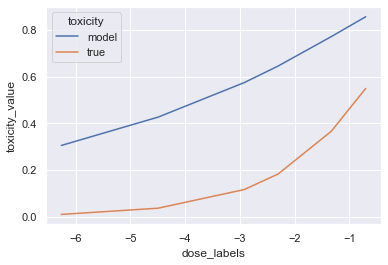

curr_s: [2 1 0]
[0.30566793 0.42705053 0.57524834 0.64621453 0.77242146 0.8573849 ]
Selected dose: 0
[-6.25907339 -6.25907339 -6.25907339] [1 0 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 36 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.09  0.03    0.04     0.15        0.0      0.0  13726.66   12948.8   

       r_hat  
alpha    1.0  
0.09347769184857702


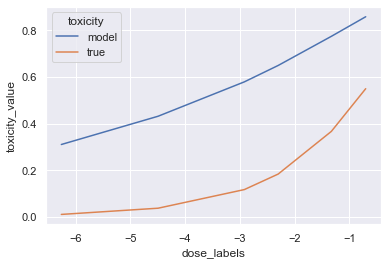

curr_s: [1 1 2]
[0.31031486 0.43170117 0.57931181 0.6498163  0.77496472 0.85906593]
Selected dose: 0
[-6.25907339 -6.25907339 -6.25907339] [1 1 1]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 37 seconds.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
There were 337 divergences after tuning. Increase `target_accept` or reparameterize.


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.07  0.02    0.03     0.11        0.0      0.0  14449.22  13335.44   

       r_hat  
alpha    1.0  
0.06663578235127858


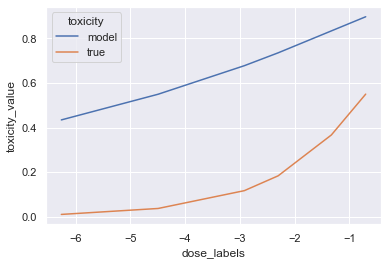

curr_s: [0 0 1]
[0.4342405  0.54946438 0.67762834 0.73544019 0.83382397 0.89736812]
Selected dose: 0
[-6.25907339 -6.25907339 -6.25907339] [0 0 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 42 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.09  0.05    0.04     0.13        0.0      0.0   3502.38   1228.12   

       r_hat  
alpha    1.0  
0.08757669382130293


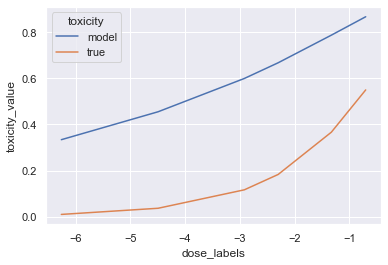

curr_s: [1 1 1]
[0.33410558 0.4552114  0.59962412 0.6677419  0.78753755 0.8673437 ]
Selected dose: 0
[-6.25907339 -6.25907339 -6.25907339] [0 1 1]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 36 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.07  0.02    0.03     0.11        0.0      0.0  14861.89  14036.69   

       r_hat  
alpha    1.0  
0.07189740384524518


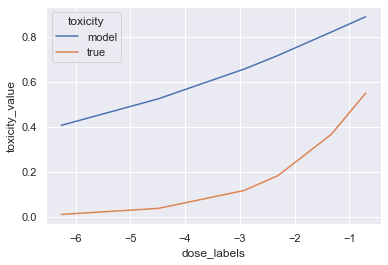

In [26]:
main()
